  Fold 1 Step 0: NLL = 6675.278185294778
  Fold 1 Step 500: NLL = 2115.9104496835253
  Fold 1 Step 1000: NLL = 1872.8230624856615
  Fold 1 Step 1500: NLL = 1746.3419088480769
Fold 1 final NLL = 1696.1833052392171
  Fold 2 Step 0: NLL = 1718.7182262148008
  Fold 2 Step 500: NLL = 1680.6639433057703
  Fold 2 Step 1000: NLL = 1666.1586671874747
  Fold 2 Step 1500: NLL = 1655.0543475388486
Fold 2 final NLL = 1674.1676603692222
  Fold 3 Step 0: NLL = 1646.2062683108798
  Fold 3 Step 500: NLL = 1553.5053875849167
  Fold 3 Step 1000: NLL = 1552.0106175098663
  Fold 3 Step 1500: NLL = 1551.339685692515
Fold 3 final NLL = 1551.9005853641324
  Fold 4 Step 0: NLL = 1683.7537531086714
  Fold 4 Step 500: NLL = 1677.368584104568
  Fold 4 Step 1000: NLL = 1689.3406585865182
  Fold 4 Step 1500: NLL = 1682.1113712311944
Fold 4 final NLL = 1643.87467295826
  Fold 5 Step 0: NLL = 1673.8047234853066
  Fold 5 Step 500: NLL = 1682.1966608981636
  Fold 5 Step 1000: NLL = 1687.8600126731765
  Fold 5 Step 1500

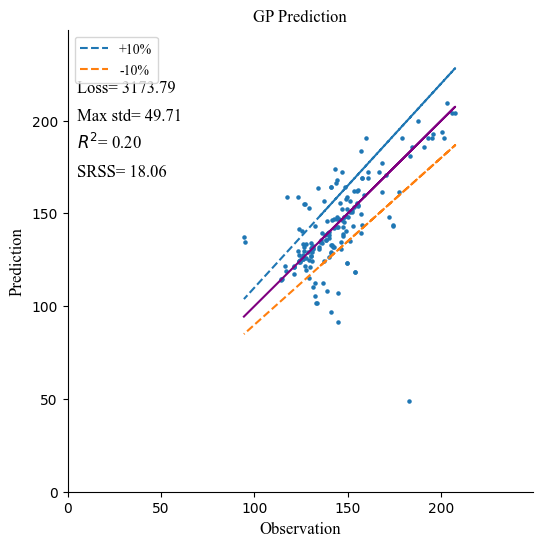

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
from numpy.polynomial.polynomial import polyfit
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
# if tf.test.gpu_device_name() != '/device:GPU:0':
#   print('WARNING: GPU device not found.')
# else:
#   print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

#读入数据
df = pd.read_excel('C:/Users/Tongrui/Desktop/UHPC1.xlsx')
df= df.dropna()
# df = df.sort_values(by=df.columns[11],ascending=False)
RawD=(df.iloc[:,:12].values).astype(np.float64)
permuted_indices = np.random.permutation(RawD.shape[0])
RawD = RawD[permuted_indices]
TrainD= RawD[:int(RawD.shape[0] * 0.8)]
TestD = RawD[int(RawD.shape[0] * 0.8):]

xT=TrainD[:,:11]
yT=TrainD[:,11]

x=TestD[:,:11]
y=TestD[:,11]
y_up=y*1.1
y_down=y*0.9

# dft = pd.read_excel('C:/Users/Tongrui/Desktop/Test.xlsx')
# dft= dft.dropna()
# xt=(dft.iloc[:,:10].values).astype(np.float64)
# yt=(dft.iloc[:,11].values).astype(np.float64)

# index_points = np.zeros((len(x), len(x[0])))
# for i in range(len(x[0])):
#     index_points[:, i] = np.linspace(np.argmin(x), np.argmax(x), len(x)).T

#模型4(Gaussion Process by tf)#######################
#定义先验核函数
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
    amplitude=tf.Variable(1, dtype=np.float64, name='amplitude'),
    length_scale=tf.Variable(1, dtype=np.float64, name='length_scale'))
noise=tf.Variable(0.2*np.mean(yT), dtype=np.float64, name='noise')

# 执行交叉验证
Vars=[]
Coefs=[]
kf = KFold(n_splits=5)
iFd=0
for train_index, test_index in kf.split(xT):
    iFd=iFd+1
    x_train, x_test = xT[train_index,:], xT[test_index,:]
    y_train, y_test = yT[train_index], yT[test_index]

    clf = linear_model.LinearRegression(fit_intercept=False)
    clf.fit(x_train, y_train)
    mean_fn=lambda t: tf.tensordot(t,clf.coef_.T,1)
    
    GP4 =tfp.distributions.GaussianProcessRegressionModel(
                                        kernel=kernel,
                                        index_points=x_train,
                                        mean_fn=mean_fn,
                                        observation_index_points=x_train,
                                        observations= y_train,
                                        observation_noise_variance=noise
                                                    )
    #定义训练优化方法，训练模型
    optimizers=tf.optimizers.Adam(learning_rate=0.02)

    @tf.function
    def optimize():
       with tf.GradientTape() as Tape:
         loss = -GP4.log_prob(y_train)
       grads = Tape.gradient(loss, GP4.trainable_variables)
       optimizers.apply_gradients(zip(grads, GP4.trainable_variables))
       return loss
        
    for i in range(2000):
        neg_log_likelihood = optimize()
        if i % 500 == 0:
          print("  Fold {} Step {}: NLL = {}".format(iFd,i,neg_log_likelihood))
    print("Fold {} final NLL = {}".format(iFd,neg_log_likelihood))
    
    Values = [var.numpy() for var in GP4.trainable_variables]
    Vars.append(Values)
    Coefs.append(clf.coef_)

#确定后验参数和模型
Var_mean=np.mean(Vars,axis=0)
Coef_mean=np.mean(Coefs,axis=0)
kernel_p = tfp.math.psd_kernels.ExponentiatedQuadratic(
    amplitude=Var_mean[0],
    length_scale=Var_mean[1])
noise_P=Var_mean[2]
mean_fn_P=lambda t: tf.tensordot(t,Coef_mean.T,1)

gp4=tfp.distributions.GaussianProcess(
    kernel=kernel_p,
    index_points=xT,
     mean_fn=mean_fn_P,
    observation_noise_variance=noise_P
   )

PR=gp4.posterior_predictive(
                             observations=yT,
                             predictive_index_points=x
                            )
py4=PR.mean()
std4=PR.stddev()

maxstd=np.max(std4)
loss=-gp4.log_prob(yT)
r_squared = r2_score(y,py4)
srss = np.sqrt(np.sum((y-py4)**2)/len(y))


plt.figure(figsize=(6, 6))
plt.title('GP Prediction',font='times new roman',fontsize=12)
plt.axis([0, np.max(y)*1.2, 0,  np.max(y)*1.2])
plt.xlabel('Observation',font='times new roman',fontsize=12)
plt.xticks(font='times new roman',fontsize=12)
plt.ylabel('Prediction',font='times new roman',fontsize=12)
plt.yticks(font='times new roman',fontsize=12)
plt.gca().spines["right"].set_color("none")
plt.gca().spines["top"].set_color("none")
plt.gca().spines["bottom"].set_position(("data", 0))
plt.gca().spines["left"].set_position(("data", 0))
plt.plot(y, y_up, label='+10%',linestyle='--')#模型6（Gaussion）
plt.plot(y, y, linestyle='-', color='purple')
plt.plot(y, y_down, label='-10%',linestyle='--')#模型6（Gaussion）
plt.scatter(y,py4,s=5)
plt.text(5, 210, "Loss= %.2f" % loss,font='times new roman',fontsize=12)
plt.text(5, 195, "Max std= %.2f" % maxstd,font='times new roman',fontsize=12)
plt.text(5, 180, "$R^{2}$= %.2f" % r_squared,font='times new roman',fontsize=12)
plt.text(5, 165, "SRSS= %.2f" % srss,font='times new roman',fontsize=12)
plt.legend(loc='upper left',prop='times new roman',fontsize=12)
plt.savefig('C:/Users/Tongrui/Desktop/2.jpeg')
plt.show()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                